In [1]:
import time
import os
import datetime
import random
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import haversine as hs
from haversine import Unit
from shapely.geometry import Point, Polygon, LineString
from math import radians, cos, sin, asin, sqrt
from collections import defaultdict





In [2]:
trips_df = pd.read_csv("../../../data/mmt_gtfs/trips.csv")
routes_df = pd.read_csv("../../../data/mmt_gtfs/routes.csv")
stops_df = pd.read_csv("../../../data/bus_route_stop_info/stops.csv")
stops_df = stops_df[stops_df["Route"] != "None"]  # filter stops that are not currently in service
stop_times_df = pd.read_csv("../../../data/mmt_gtfs/stop_times.csv")
city = gpd.read_file("../../../data/plot/background/madison-shp")
water = gpd.read_file("../../../data/plot/background/water-shp")
street = gpd.read_file("../../../data/plot/background/streets-shp")
zones = gpd.read_file("../../../data/plot/background/zoning_districts-shp")
zones = zones.dropna(subset=["ZONING_COD"])

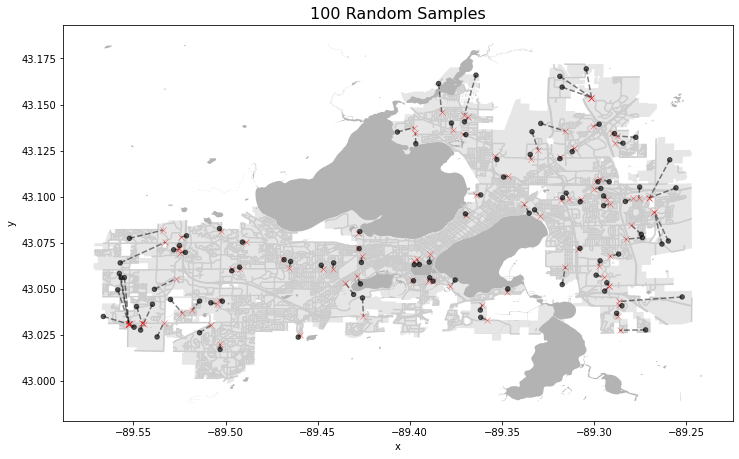

In [12]:
def generate_random(num_points, polygons):
    """
    take as input a numpoints and a list of polygons,
    output a list of points within the given polygons

    :param num_points: number of points generated
    :param polygons: a list of Shapely Polygon
    """
    points = []

    while len(points) < num_points:
        choice = random.choice(range(len(polygons)))
        polygon = polygons[choice]
        minx, miny, maxx, maxy = polygon.bounds
        pnt = Point(random.uniform(round(minx, 2), round(maxx, 2)),
                    random.uniform(round(miny, 2), round(maxy, 2)))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

def plot_random(num_points, ax, **kwargs):
    text_offset = 0.0008
    names = []
    colors = []
    x = []
    y = []
    points = generate_random(num_points, list(city.geometry))
    for idx, p in enumerate(points):

        # randomly generate colors (re-adjust so it's more visibly clear)

        # option 1: generate random colors
        # r = lambda: random.randint(0,255)
        # c = '#%02X%02X%02X' % (r(),r(),r())

        # option 2: all black colors
        c = "k"
        colors.append(c)

        # pt names
        pt_name = "p" + str(idx)
        names.append(pt_name)

        x.append(float(p.x))
        y.append(float(p.y))

        # marking each generated points
        # ax.text(p.x + text_offset, p.y, pt_name, va="bottom", ha="left", c=c)
    df = pd.DataFrame({"name":names, "x":x, "y":y, "color":colors})
    df.plot.scatter("x", "y", ax=ax, c=colors, **kwargs)
    return colors, points


def find_nearest(points):
    """
    Find the nearest bus stops for each point in the points parameter.

    :param points: a list of shapely Point objects
    :return: a DataFrame of columns: stop_id, lon, lat, distance in miles
    """
    ids = []
    lons = []
    lats = []
    dists = []
    for p in points:
        x = p.x
        y = p.y

        # element wise operation to find the smallest value
        euclidean = (stops_df["stop_lon"] - x) ** 2 + (stops_df["stop_lat"] - y) ** 2
        idx = euclidean.idxmin()  # index of the smallest value

        stop_id = stops_df.loc[euclidean.idxmin(), "stop_id"]
        lon = stops_df.loc[euclidean.idxmin(), "stop_lon"]
        lat = stops_df.loc[euclidean.idxmin(), "stop_lat"]
        dist = hs.haversine((x, y), (lon, lat), unit=Unit.MILES)  # in miles
        dist = dist * 1609.34  # in meters

        ids.append(stop_id)
        lons.append(lon)
        lats.append(lat)
        dists.append(dist)
    stops = pd.DataFrame({
        "stop_id": ids,
        "lon": lons,
        "lat": lats,
        "distance (in meters)": dists
    })
    return stops

def connect_to_stops(ax, points, stops):
    """
    Draw a line from randomly generated points to nearest bus stops that are in service.

    :param stops: stops dataframe that have columns stop_id, lat, lon, dist
    :param ax: Axes object to plot
    :return: None
    """
    linestrings = []
    for idx, row in stops.iterrows():
        ls = LineString([(points[idx].x, points[idx].y), (row["lon"], row["lat"])])
        linestrings.append(ls)

    df = pd.DataFrame({"geometry":linestrings})
    df.set_geometry("geometry").plot(ax=ax, color="k", linestyle="--", alpha=0.5)

def generate_plot(num_points, t, serv):
    """
    generate a geo map with randomly generated points, and connect the
    generated points with the nearest bus stops

    :param num_points: number of random points to be generated, user input
    :return: TBD
    """

    serv_types = {"wkd":"93_WKD",
                  "sat":"93_SAT",
                  "sun":"93_SUN",
                  "hol":"93_HOL",
                  "mwk":"93_MWK"}

    # --------- plot background ---------
    fig, ax = plt.subplots(figsize=(12, 10))
    city.plot(ax=ax, color="0.9")
    water.plot(ax=ax, color="0.7")
    street.plot(ax=ax, color="0.8")

    dot_size = 20
    # --------- plot random points ---------
    colors, points = plot_random(num_points=num_points, ax=ax, s=dot_size, zorder=5, alpha=0.6)

    # --------- plot bus stops ---------
    stops = find_nearest(points)
    # stops.plot.scatter("lon", "lat", ax=ax, c=colors, s=35, zorder=5, alpha=0.4, marker='o', facecolor="None")
    plt.plot(stops["lon"],stops["lat"], 'x', markersize=dot_size*0.3, markerfacecolor="None",
             markeredgecolor="red", markeredgewidth=0.5, alpha=0.6)

    # --------- draw lines between pts and stops ---------
    connect_to_stops(ax, points, stops)
    ax.set_title(str(num_points) + " Random Samples", size=16)

    # --------- save figure to file ---------
    # TODO: when save, uncomment this
    # ax.set_axis_off()
    #
    # if not os.path.exists("sim_sample"):
    #     os.mkdir("sim_sample")
    #
    # current_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H-%M-%S')
    # dirname = current_time[:current_time.index("_")]
    #
    # if not os.path.exists(os.path.join("sim_sample", dirname)):
    #     os.mkdir(os.path.join("sim_sample", dirname))
    #
    # plt.savefig(os.path.join("sim_sample",
    #                          dirname,
    #                         (current_time[current_time.index("_"):] + ".png")),
    #             dpi=300, bbox_inches="tight")


    # --------- add routes to stops ---------
    routes = []
    for idx, row in stops.iterrows():
        stop_id = row["stop_id"]
        routes.append(stops_df[stops_df["stop_id"].isin([stop_id])]["Route"].iloc[0])

    stops["routes"] = routes

    # --------- find soonest coming bus ---------
    matched_stops = stop_times_df[stop_times_df["stop_id"].isin(stops["stop_id"])]
    # matched_stops
    trips_by_serv = trips_df[trips_df["service_id"].str.contains(serv_types[serv])]
    filtered_trips = trips_by_serv[trips_by_serv["trip_id"].isin(matched_stops["trip_id"])]
    # filtered_trips
    matched_trips = stop_times_df[stop_times_df["trip_id"].isin(filtered_trips["trip_id"])]
    matched_trips
    matched_trips[matched_trips["stop_id"].isin(stops["stop_id"])]



    return stops

t = datetime.time(7, 30, 00)
serv = "wkd"
stops = generate_plot(100, t, serv)

In [13]:
stops

,stop_id,lon,lat,distance (in meters),routes
0,7734,-89.313578,43.098540,165.751566,"30, 32"
1,2561,-89.428227,43.071996,85.280258,"2, 10, 44, 48"
2,9364,-89.330324,43.125413,368.030122,6
3,2773,-89.426054,43.067824,19.719671,6
4,9349,-89.290156,43.134323,141.711447,26
...,...,...,...,...,...
95,7815,-89.294725,43.056247,456.898838,39
96,3351,-89.360792,43.041300,99.997359,11
97,7587,-89.269884,43.099311,1225.273706,33
98,1225,-89.329138,43.089689,344.973051,"16, 31"


In [14]:
serv_types = {"wkd":"93_WKD",
              "sat":"93_SAT",
              "sun":"93_SUN",
              "hol":"93_HOL",
              "mwk":"93_MWK"}

start = time.time()
min_trip_ids = []
min_waits = []

for idx, row in stops.iterrows():
    # stop_times_df["stop_id"] x stops["stop_id"]
    matched_stops = stop_times_df[stop_times_df["stop_id"].isin([row["stop_id"]])]

    # filtered_trip["trip_id"] x matched_stops["trip_id"]
    trips_by_serv = trips_df[trips_df["service_id"].str.contains(serv_types[serv])]
    filtered_trips = trips_by_serv[trips_by_serv["trip_id"].isin(matched_stops["trip_id"])]

    # stop_times_df["trip_id"] x filtered_trips["trip_id"]
    matched_trips = stop_times_df[stop_times_df["trip_id"].isin(filtered_trips["trip_id"])]

    # matched_trips["stop_id"] x stops["stop_id"]
    matched = matched_trips[matched_trips["stop_id"].isin([row["stop_id"]])]

    # arrivals = matched[matched["arrival_time"].str.startswith(str(t.hour)) | matched["arrival_time"].str.startswith(str(t.hour + 1))]


    trip_min = 0
    wait_min = float("inf")
    for idx1, row1 in matched.iterrows():
        arrival = row1["arrival_time"].split(":")
        h = int(arrival[0])
        m = int(arrival[1])
        s = int(arrival[2])
        arr_td = datetime.timedelta(hours=h, minutes=m, seconds=s)
        td = datetime.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)
        time_diff = arr_td - td
        if time_diff.days == 0 and time_diff.seconds < wait_min:
            wait_min = time_diff.seconds
            trip_min = row1["trip_id"]

    min_trip_ids.append(trip_min)
    min_waits.append(round(wait_min / 60, 2))

stops["minutes_wait"] = min_waits
stops["trip_id"] = min_trip_ids

end = time.time()
print(str(round((end - start) * 1000, 2)) + "ms")

stops

# TODO: Add distance travel


1748.11ms


,stop_id,lon,lat,distance (in meters),routes,minutes_wait,trip_id
0,7734,-89.313578,43.098540,165.751566,"30, 32",8.12,1023276
1,2561,-89.428227,43.071996,85.280258,"2, 10, 44, 48",14.00,1023552
2,9364,-89.330324,43.125413,368.030122,6,5.62,1020100
3,2773,-89.426054,43.067824,19.719671,6,10.22,1020061
4,9349,-89.290156,43.134323,141.711447,26,7.45,1022634
...,...,...,...,...,...,...,...
95,7815,-89.294725,43.056247,456.898838,39,28.00,1023427
96,3351,-89.360792,43.041300,99.997359,11,48.10,1020991
97,7587,-89.269884,43.099311,1225.273706,33,23.58,1023344
98,1225,-89.329138,43.089689,344.973051,"16, 31",5.77,1021233


In [ ]:

zones.head()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
zones[zones["ZONING_COD"].str.startswith("SR")].plot(ax=ax)

In [ ]:
trip_ids = [1022598, 1022597, 1022596, 1022595, 1022594, 1022593, 1022592, 1022605, 1022604, 1022603, 1022602, 1022601, 1022600, 1022599]
df = stop_times_df[stop_times_df["trip_id"].isin(trip_ids)]
df[df["stop_id"] == 9196]
df["stop_headsign"].value_counts()